# Clouds of Points

#### Before visualizing the posterior distribution, we are conducting a frequentist-taste? analysis. 
#### This code corresponds to Chapter 8.1 in my thesis and figures 8.1, 8.2, 8.3, 8.4, 8.5, and 8.6.

# Part 1. Enviroment setting

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
#import IPython
#print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

In [2]:
#%matplotlib notebook
import os
os.chdir("/home/r/R.Kanaki/Masterarbeit/מייַ_2023/prior_consideration")
import healpy as heal
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from healpy_networks_custom import HealpyGCNN
import healpy_layers_custom as hp_layer
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
from standard_2D import Standardize_Min_Max_2D, Rescale_MSE_Min_Max_2D
import build_model
from Loss_mean import MyLoss
from livelossplot import PlotLossesKeras
from cov_by_hand import cov, chisq
import pandas as pd
import tensorflow as tf
tf.keras.backend.clear_session()

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
training_data_lognormal_1      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Training/NSIDE128/train_lognormal.npz')
training_data_lognormal_2      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Training/NSIDE128/train_lognormal.npz')
training_data_Gauss_1          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Training/NSIDE128/train_Gauss.npz')
training_data_Gauss_2          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Training/NSIDE128/train_Gauss.npz')
testing_data_T17               = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/bin34/T17_downgraded_to_128.npz')
testing_data_lognormal_1       = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_lognormal.npz')
testing_data_lognormal_2       = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Test/NSIDE128/Test_lognormal.npz')
testing_data_Gauss_1           = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_Gauss.npz')
testing_data_Gauss_2           = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Test/NSIDE128/Test_Gauss.npz')
validation_data_Gauss          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Validation/NSIDE128/train_Gauss.npz')
validation_data_lognormal      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Validation/NSIDE128/train_lognormal.npz')

In [5]:
## For lognormal realization of flask maps, cosmology is same 
train_data_lognormal_1           = training_data_lognormal_1['lognormal_map']
train_data_lognormal_2           = training_data_lognormal_2['lognormal_map']
train_data_Gauss_1               = training_data_Gauss_1['lognormal_map']
train_data_Gauss_2               = training_data_Gauss_2['lognormal_map']
val_data_lognormal               = validation_data_lognormal['lognormal_map']
val_data_Gauss                   = validation_data_Gauss['lognormal_map']
test_data_T17                    = testing_data_T17['lognormal_map']
test_data_lognormal_1            = testing_data_lognormal_1['lognormal_map']
test_data_lognormal_2            = testing_data_lognormal_2['lognormal_map']
test_data_Gauss_1                = testing_data_Gauss_1['lognormal_map']
test_data_Gauss_2                = testing_data_Gauss_2['lognormal_map']

train_label_Omega_M_Gauss       = training_data_Gauss_1['Omega_M']
train_label_sigma_8_Gauss       = training_data_Gauss_1['sigma_8']
val_label_Omega_M_Gauss         = validation_data_Gauss['Omega_M']
val_label_sigma_8_Gauss         = validation_data_Gauss['sigma_8']
train_label_Omega_M_lognormal   = training_data_lognormal_1['Omega_M']
train_label_sigma_8_lognormal   = training_data_lognormal_1['sigma_8']
val_label_Omega_M_lognormal     = validation_data_lognormal['Omega_M']
val_label_sigma_8_lognormal     = validation_data_lognormal['sigma_8']
test_label_Omega_M_T17          = testing_data_T17['Omega_M']
test_label_sigma_8_T17          = testing_data_T17['sigma_8']
test_label_Omega_M_lognormal    = testing_data_lognormal_1['Omega_M']
test_label_sigma_8_lognormal    = testing_data_lognormal_1['sigma_8']
test_label_Omega_M_Gauss        = testing_data_Gauss_1['Omega_M']
test_label_sigma_8_Gauss        = testing_data_Gauss_1['sigma_8']

In [6]:
fiducial_Omega_M = test_label_Omega_M_T17[0]
fiducial_sigma_8 = test_label_sigma_8_T17[0]

In [7]:
train_labels_Gauss          = np.zeros((10000,2))
train_labels_lognormal      = np.zeros((10000,2))
validation_labels_Gauss     = np.zeros((2500,2))
validation_labels_lognormal = np.zeros((2500,2))
test_labels_T17             = np.zeros((108,2))
test_labels_Gauss           = np.zeros((300,2))
test_labels_lognormal       = np.zeros((300,2))
for i in range(len(train_label_Omega_M_Gauss)):
    train_labels_Gauss[i]          = np.array((train_label_Omega_M_Gauss[i], train_label_sigma_8_Gauss[i]))
    train_labels_lognormal[i]      = np.array((train_label_Omega_M_lognormal[i], train_label_sigma_8_lognormal[i]))
for i in range(len(val_label_sigma_8_Gauss)):
    validation_labels_Gauss[i]     = np.array((val_label_Omega_M_Gauss[i], val_label_sigma_8_Gauss[i]))
    validation_labels_lognormal[i] = np.array((val_label_Omega_M_lognormal[i], val_label_sigma_8_lognormal[i]))
for i in range(len(test_label_Omega_M_T17)):
    test_labels_T17[i]             =np.array((test_label_Omega_M_T17[i], test_label_sigma_8_T17[i]))
for i in range(len(test_label_Omega_M_lognormal)):
    test_labels_lognormal[i]       =np.array((test_label_Omega_M_lognormal[i], test_label_sigma_8_lognormal[i]))
    test_labels_Gauss[i]           =np.array((test_label_Omega_M_Gauss[i], test_label_sigma_8_Gauss[i]))

In [8]:
def data_preprocessing_train(maps):
    outputs = maps.astype(np.float32)[..., None]
    np.random.RandomState(11).shuffle(outputs)
    return outputs

def data_preprocessing_test(maps):
    outputs = maps.astype(np.float32)[..., None]
    return outputs

def data_preprocessing_label_train(label):
    outputs = label.astype(np.float32)
    np.random.RandomState(11).shuffle(outputs)
    return outputs

def data_preprocessing_label_test(label):
    outputs = label.astype(np.float32)
    return outputs

In [9]:
lognormal_train_1        = data_preprocessing_train(train_data_lognormal_1)
lognormal_train_2        = data_preprocessing_train(train_data_lognormal_2)
lognormal_val            = data_preprocessing_train(val_data_lognormal)
Gauss_train_1            = data_preprocessing_train(train_data_Gauss_1)
Gauss_train_2            = data_preprocessing_train(train_data_Gauss_2)
Gauss_val                = data_preprocessing_train(val_data_Gauss)
T17_test                 = data_preprocessing_test(test_data_T17)
lognormal_test_1         = data_preprocessing_test(test_data_lognormal_1)
lognormal_test_2         = data_preprocessing_test(test_data_lognormal_2)
Gauss_test_1             = data_preprocessing_test(test_data_Gauss_1)
Gauss_test_2             = data_preprocessing_test(test_data_Gauss_2)
labels_train_lognormal   = data_preprocessing_label_train(train_labels_lognormal)
labels_val_lognormal     = data_preprocessing_label_train(validation_labels_lognormal)
labels_train_Gauss       = data_preprocessing_label_train(train_labels_Gauss)
labels_val_Gauss         = data_preprocessing_label_train(validation_labels_Gauss)
labels_test_T17          = data_preprocessing_label_test(test_labels_T17)
labels_test_lognormal    = data_preprocessing_label_test(test_labels_lognormal)
labels_test_Gauss        = data_preprocessing_label_test(test_labels_Gauss)

In [10]:
%matplotlib inline

In [12]:
nside=128
npix = heal.nside2npix(nside)
indices = np.arange(npix)

In [13]:
def create_lognormal_model_1(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_lognormal_model_2(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_Gaussian_model_1(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_Gaussian_model_2(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model

In [14]:
loss_fc=MyLoss()
path_lognormal_1 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/lognormal_model_ver5'
callbacks_lognormal = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_lognormal_1,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_lognormal_2 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/lognormal_model_ver7'
callbacks_lognormal_2 = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_lognormal_2,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_Gauss_1 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/Gauss_model_ver11'
callbacks_Gauss_1 = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_Gauss_1,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_Gauss_2='/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/Gauss_model_ver12'
callbacks_Gauss = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_Gauss_2,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.0001,
    decay_steps = 3000,
    end_learning_rate=0.00001,
    power=1.0,
    cycle=False,
    name=None
)

In [15]:
checkpoint_path_lognormal_1 = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_lognormal_1/checkpoints/lognormal_weights.h5'
checkpoint_path_lognormal_2 = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_lognormal_2/checkpoints/lognormal_weights.h5'
checkpoint_path_Gauss_1     = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_Gauss_1/checkpoints/lognormal_weights.h5'
checkpoint_path_Gauss_2     = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_Gauss_2/checkpoints/lognormal_weights.h5'

In [16]:
from keras import backend as K 
model_Gauss_1 = create_Gaussian_model_1(nside, indices)
model_Gauss_1.summary()
model_Gauss_1.load_weights(checkpoint_path_Gauss_1 , by_name=True)
model_Gauss_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_Gauss_1            = model_Gauss_1.predict(T17_test)
prediction_lognormal_1_Gauss_1    = model_Gauss_1.predict(lognormal_test_1)
prediction_Gauss_1_Gauss_1        = model_Gauss_1.predict(Gauss_test_1)
prediction_lognormal_2_Gauss_1    = model_Gauss_1.predict(lognormal_test_2)
prediction_Gauss_2_Gauss_1        = model_Gauss_1.predict(Gauss_test_2)
prediction_val_Gauss_1            = model_Gauss_1.predict(Gauss_val)
print(prediction_val_Gauss_1[1,0])
K.clear_session()
model_Gauss_2 = create_Gaussian_model_2(nside, indices)
model_Gauss_2.summary()
model_Gauss_2.load_weights(checkpoint_path_Gauss_2 , by_name=True)
model_Gauss_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_Gauss_2            = model_Gauss_2.predict(T17_test)
prediction_lognormal_1_Gauss_2    = model_Gauss_2.predict(lognormal_test_1)
prediction_Gauss_1_Gauss_2        = model_Gauss_2.predict(Gauss_test_1)
prediction_lognormal_2_Gauss_2    = model_Gauss_2.predict(lognormal_test_2)
prediction_Gauss_2_Gauss_2        = model_Gauss_2.predict(Gauss_test_2)
prediction_val_Gauss_2            = model_Gauss_2.predict(Gauss_val)
print(prediction_val_Gauss_2[1,0])
K.clear_session()
model_lognormal_1 = create_lognormal_model_1(nside, indices)
model_lognormal_1.summary()
model_lognormal_1.load_weights(checkpoint_path_lognormal_1, by_name=True)
model_lognormal_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_lognormal_1            = model_lognormal_1.predict(T17_test)
prediction_lognormal_1_lognormal_1    = model_lognormal_1.predict(lognormal_test_1)
prediction_Gauss_1_lognormal_1        = model_lognormal_1.predict(Gauss_test_1)
prediction_lognormal_2_lognormal_1    = model_lognormal_1.predict(lognormal_test_2)
prediction_Gauss_2_lognormal_1        = model_lognormal_1.predict(Gauss_test_2)
prediction_val_lognormal_1            = model_lognormal_1.predict(Gauss_val)
print(prediction_val_lognormal_1[1,0])
K.clear_session()
model_lognormal_2 = create_lognormal_model_2(nside, indices)
model_lognormal_2.summary()
model_lognormal_2.load_weights(checkpoint_path_lognormal_2, by_name=True)
model_lognormal_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_lognormal_2            = model_lognormal_2.predict(T17_test)
prediction_lognormal_1_lognormal_2    = model_lognormal_2.predict(lognormal_test_1)
prediction_Gauss_1_lognormal_2        = model_lognormal_2.predict(Gauss_test_1)
prediction_lognormal_2_lognormal_2    = model_lognormal_2.predict(lognormal_test_2)
prediction_Gauss_2_lognormal_2        = model_lognormal_2.predict(Gauss_test_2)
prediction_val_lognormal_2            = model_lognormal_2.predict(Gauss_val)
print(prediction_val_lognormal_2[1,0])
K.clear_session()

Detected a reduction factor of 64.0, the input with nside 128 will be transformed to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 chebyshev (Chebyshev)       (None, 196608, 10)        50        
                                                                 
 healpy_pool (HealpyPool)    (None, 49152, 10)         0         
                                                                 
 chebyshev_1 (Chebyshev)     (None, 49152, 10)         500       
                                                                 
 healpy_pool_1 (HealpyPool)  (None, 12288, 10)         0         
                                                                 
 chebyshev_2 (Chebyshev)     (None, 12288, 10)         500       
                                                                 
 healpy

# Part 2. Cluster of Points

#### Visualize simply the first two outputs of GCNN models.

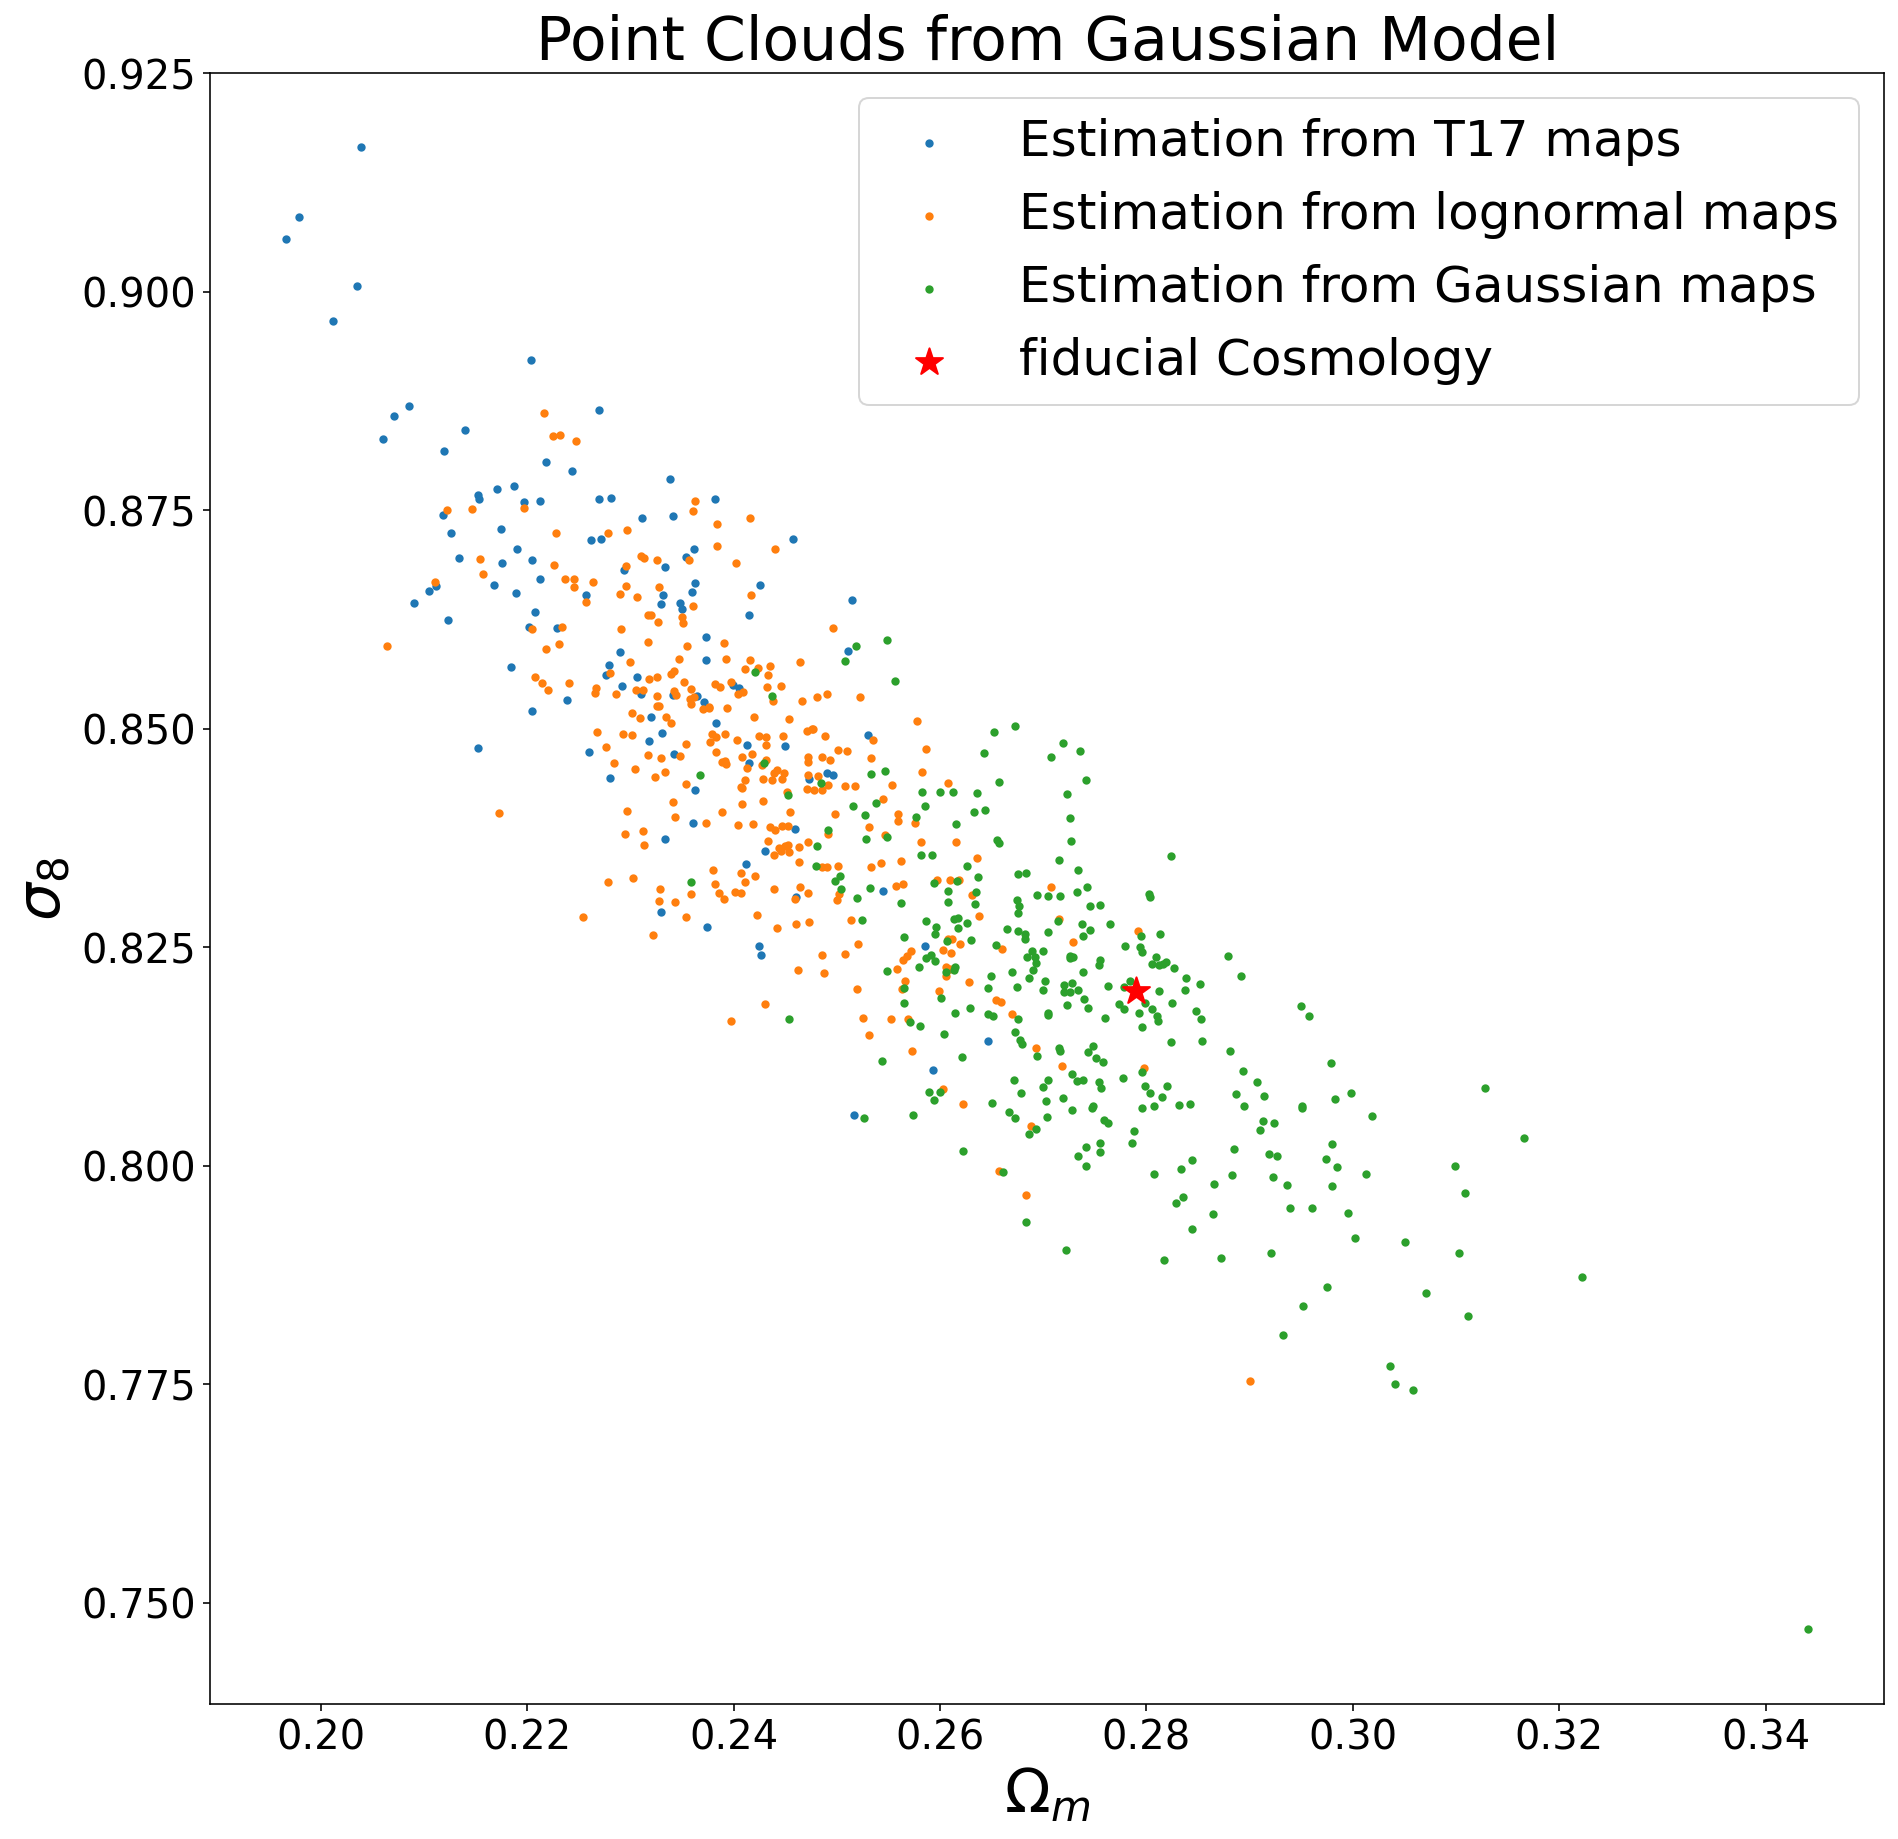

In [20]:
plt.figure(figsize=(15,15))
plt.scatter(prediction_T17_Gauss_1[:,0],prediction_T17_Gauss_1[:,1], label=f'Estimation from T17 maps',s=10)
plt.scatter(prediction_lognormal_1_Gauss_1[:,0],prediction_lognormal_1_Gauss_1[:,1], label=f'Estimation from lognormal maps',s=10)
plt.scatter(prediction_Gauss_1_Gauss_1[:,0],prediction_Gauss_1_Gauss_1[:,1], label=f'Estimation from Gaussian maps',s=10)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', label='fiducial Cosmology', s=200, color="red")
plt.legend(fontsize=25) 
plt.title('Point Clouds from Gaussian Model',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(f"$\sigma_8$", fontsize=30)
plt.xlabel(f"$\Omega_m$", fontsize=30)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Test_prediction_2D_Gauss_11.png',bbox_inches='tight')
plt.show();

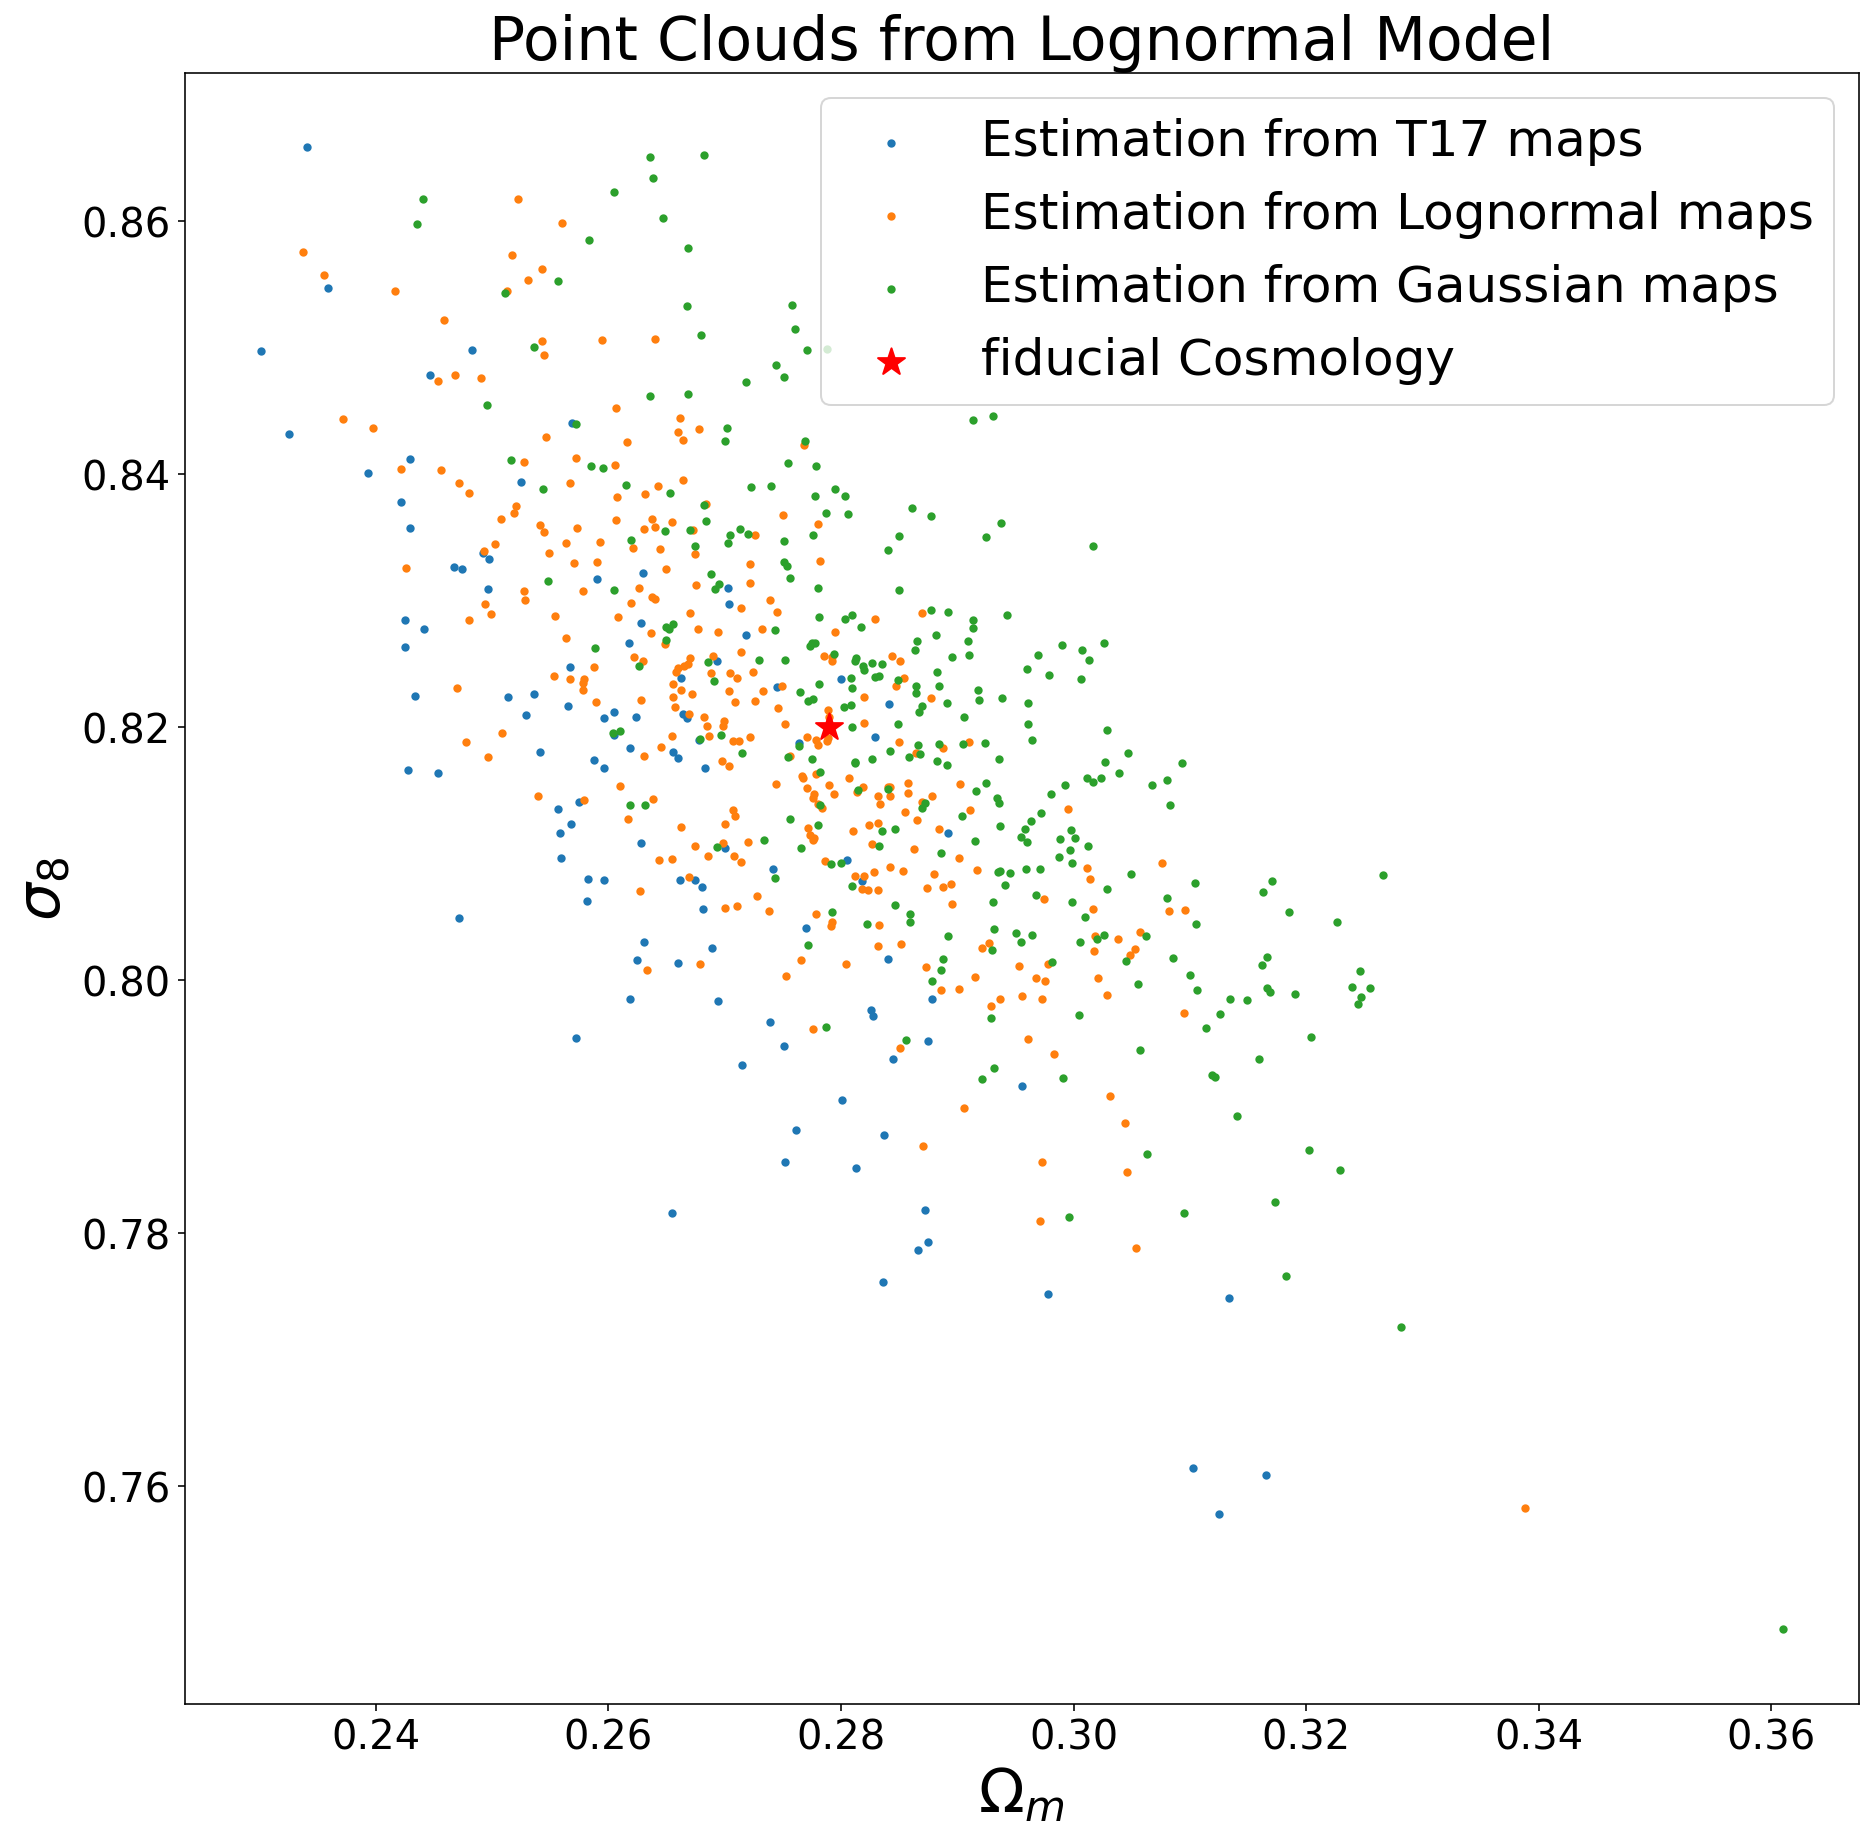

In [21]:
plt.figure(figsize=(15,15))
plt.scatter(prediction_T17_lognormal_1[:,0],prediction_T17_lognormal_1[:,1], label=f'Estimation from T17 maps',s=10)
plt.scatter(prediction_lognormal_1_lognormal_1[:,0],prediction_lognormal_1_lognormal_1[:,1], label=f'Estimation from Lognormal maps',s=10)
plt.scatter(prediction_Gauss_1_lognormal_1[:,0],prediction_Gauss_1_lognormal_1[:,1], label=f'Estimation from Gaussian maps',s=10)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', label='fiducial Cosmology', s=200, color="red")
plt.legend(fontsize=25) 
plt.title('Point Clouds from Lognormal Model',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(f"$\sigma_8$", fontsize=30)
plt.xlabel(f"$\Omega_m$", fontsize=30)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Test_prediction_2D_lognormal_11.png',bbox_inches='tight')
plt.show();

#### Visually we can as follows:
#### Train with Gaussian  -> Test with Gaussian  -> unbiased
#### Train with Gaussian  -> Test with Lognormal -> biased
#### Train with Gaussian  -> Test with T17       -> biased
#### Train with lognormal -> Test with Gaussian  -> unbiased
#### Train with lognormal -> Test with lognormal -> unbiased
#### Train with lognormal -> Test with T17       -> unbiased

# Part 3. Bias and Variance

#### We define the bias and variance as follows:
$$
Bias=\theta_{fid}-\langle\theta_{est}\rangle\\
Variance=\frac{1}{N-1}\sum^{N}_{i=1}(\theta_{est,i}-\langle\theta_{est}\rangle)^2
$$

In [22]:
def bias_predic(fiducial,prediction_mean):
    bias = fiducial-prediction_mean
    return bias

def variance_predic(prediction_vec, prediction_mean):
    var = np.sum((prediction_vec-prediction_mean)**2)/(len(prediction_vec)-1)
    return var

def mean_predic(prediction):
    mean = np.mean(prediction)
    return mean

def bias_var_mean(fiducial, prediction):
    mean = mean_predic(prediction)
    bias = bias_predic(fiducial, mean)
    var  = variance_predic(prediction, mean)
    return mean, bias, var

In [23]:
prediction_T17_Gauss_1_Omega_M_mean, bias_T17_Gauss_1_Omega_M, var_T17_Gauss_1_Omega_M                                       = bias_var_mean(fiducial_Omega_M, prediction_T17_Gauss_1[:,0])
prediction_T17_Gauss_2_Omega_M_mean, bias_T17_Gauss_2_Omega_M, var_T17_Gauss_2_Omega_M                                       = bias_var_mean(fiducial_Omega_M, prediction_T17_Gauss_2[:,0])
prediction_T17_lognormal_1_Omega_M_mean, bias_T17_lognormal_1_Omega_M, var_T17_lognormal_1_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_T17_lognormal_1[:,0])
prediction_T17_lognormal_2_Omega_M_mean, bias_T17_lognormal_2_Omega_M, var_T17_lognormal_2_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_T17_lognormal_2[:,0])
prediction_lognormal_1_Gauss_1_Omega_M_mean, bias_lognormal_1_Gauss_1_Omega_M, var_lognormal_1_Gauss_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_Gauss_1[:,0])
prediction_lognormal_2_Gauss_1_Omega_M_mean, bias_lognormal_2_Gauss_1_Omega_M, var_lognormal_2_Gauss_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_Gauss_1[:,0])
prediction_lognormal_1_Gauss_2_Omega_M_mean, bias_lognormal_1_Gauss_2_Omega_M, var_lognormal_1_Gauss_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_Gauss_2[:,0])
prediction_lognormal_2_Gauss_2_Omega_M_mean, bias_lognormal_2_Gauss_2_Omega_M, var_lognormal_2_Gauss_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_Gauss_2[:,0])
prediction_lognormal_1_lognormal_1_Omega_M_mean, bias_lognormal_1_lognormal_1_Omega_M, var_lognormal_1_lognormal_1_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_lognormal_1[:,0])
prediction_lognormal_2_lognormal_1_Omega_M_mean, bias_lognormal_2_lognormal_1_Omega_M, var_lognormal_2_lognormal_1_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_lognormal_1[:,0])
prediction_lognormal_1_lognormal_2_Omega_M_mean, bias_lognormal_1_lognormal_2_Omega_M, var_lognormal_1_lognormal_2_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_lognormal_2[:,0])
prediction_lognormal_2_lognormal_2_Omega_M_mean, bias_lognormal_2_lognormal_2_Omega_M, var_lognormal_2_lognormal_2_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_lognormal_2[:,0])
prediction_Gauss_1_Gauss_1_Omega_M_mean, bias_Gauss_1_Gauss_1_Omega_M, var_Gauss_1_Gauss_1_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_Gauss_1[:,0])
prediction_Gauss_2_Gauss_1_Omega_M_mean, bias_Gauss_2_Gauss_1_Omega_M, var_Gauss_2_Gauss_1_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_Gauss_1[:,0])
prediction_Gauss_1_Gauss_2_Omega_M_mean, bias_Gauss_1_Gauss_2_Omega_M, var_Gauss_1_Gauss_2_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_Gauss_2[:,0])
prediction_Gauss_2_Gauss_2_Omega_M_mean, bias_Gauss_2_Gauss_2_Omega_M, var_Gauss_2_Gauss_2_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_Gauss_2[:,0])
prediction_Gauss_1_lognormal_1_Omega_M_mean, bias_Gauss_1_lognormal_1_Omega_M, var_Gauss_1_lognormal_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_lognormal_1[:,0])
prediction_Gauss_2_lognormal_1_Omega_M_mean, bias_Gauss_2_lognormal_1_Omega_M, var_Gauss_2_lognormal_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_lognormal_1[:,0])
prediction_Gauss_1_lognormal_2_Omega_M_mean, bias_Gauss_1_lognormal_2_Omega_M, var_Gauss_1_lognormal_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_lognormal_2[:,0])
prediction_Gauss_2_lognormal_2_Omega_M_mean, bias_Gauss_2_lognormal_2_Omega_M, var_Gauss_2_lognormal_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_lognormal_2[:,0])

prediction_T17_Gauss_1_sigma_8_mean, bias_T17_Gauss_1_sigma_8, var_T17_Gauss_1_sigma_8                                       = bias_var_mean(fiducial_sigma_8, prediction_T17_Gauss_1[:,1])
prediction_T17_Gauss_2_sigma_8_mean, bias_T17_Gauss_2_sigma_8, var_T17_Gauss_2_sigma_8                                       = bias_var_mean(fiducial_sigma_8, prediction_T17_Gauss_2[:,1])
prediction_T17_lognormal_1_sigma_8_mean, bias_T17_lognormal_1_sigma_8, var_T17_lognormal_1_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_T17_lognormal_1[:,1])
prediction_T17_lognormal_2_sigma_8_mean, bias_T17_lognormal_2_sigma_8, var_T17_lognormal_2_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_T17_lognormal_2[:,1])
prediction_lognormal_1_Gauss_1_sigma_8_mean, bias_lognormal_1_Gauss_1_sigma_8, var_lognormal_1_Gauss_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_Gauss_1[:,1])
prediction_lognormal_2_Gauss_1_sigma_8_mean, bias_lognormal_2_Gauss_1_sigma_8, var_lognormal_2_Gauss_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_Gauss_1[:,1])
prediction_lognormal_1_Gauss_2_sigma_8_mean, bias_lognormal_1_Gauss_2_sigma_8, var_lognormal_1_Gauss_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_Gauss_2[:,1])
prediction_lognormal_2_Gauss_2_sigma_8_mean, bias_lognormal_2_Gauss_2_sigma_8, var_lognormal_2_Gauss_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_Gauss_2[:,1])
prediction_lognormal_1_lognormal_1_sigma_8_mean, bias_lognormal_1_lognormal_1_sigma_8, var_lognormal_1_lognormal_1_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_lognormal_1[:,1])
prediction_lognormal_2_lognormal_1_sigma_8_mean, bias_lognormal_2_lognormal_1_sigma_8, var_lognormal_2_lognormal_1_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_lognormal_1[:,1])
prediction_lognormal_1_lognormal_2_sigma_8_mean, bias_lognormal_1_lognormal_2_sigma_8, var_lognormal_1_lognormal_2_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_lognormal_2[:,1])
prediction_lognormal_2_lognormal_2_sigma_8_mean, bias_lognormal_2_lognormal_2_sigma_8, var_lognormal_2_lognormal_2_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_lognormal_2[:,1])
prediction_Gauss_1_Gauss_1_sigma_8_mean, bias_Gauss_1_Gauss_1_sigma_8, var_Gauss_1_Gauss_1_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_Gauss_1[:,1])
prediction_Gauss_2_Gauss_1_sigma_8_mean, bias_Gauss_2_Gauss_1_sigma_8, var_Gauss_2_Gauss_1_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_Gauss_1[:,1])
prediction_Gauss_1_Gauss_2_sigma_8_mean, bias_Gauss_1_Gauss_2_sigma_8, var_Gauss_1_Gauss_2_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_Gauss_2[:,1])
prediction_Gauss_2_Gauss_2_sigma_8_mean, bias_Gauss_2_Gauss_2_sigma_8, var_Gauss_2_Gauss_2_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_Gauss_2[:,1])
prediction_Gauss_1_lognormal_1_sigma_8_mean, bias_Gauss_1_lognormal_1_sigma_8, var_Gauss_1_lognormal_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_lognormal_1[:,1])
prediction_Gauss_2_lognormal_1_sigma_8_mean, bias_Gauss_2_lognormal_1_sigma_8, var_Gauss_2_lognormal_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_lognormal_1[:,1])
prediction_Gauss_1_lognormal_2_sigma_8_mean, bias_Gauss_1_lognormal_2_sigma_8, var_Gauss_1_lognormal_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_lognormal_2[:,1])
prediction_Gauss_2_lognormal_2_sigma_8_mean, bias_Gauss_2_lognormal_2_sigma_8, var_Gauss_2_lognormal_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_lognormal_2[:,1])

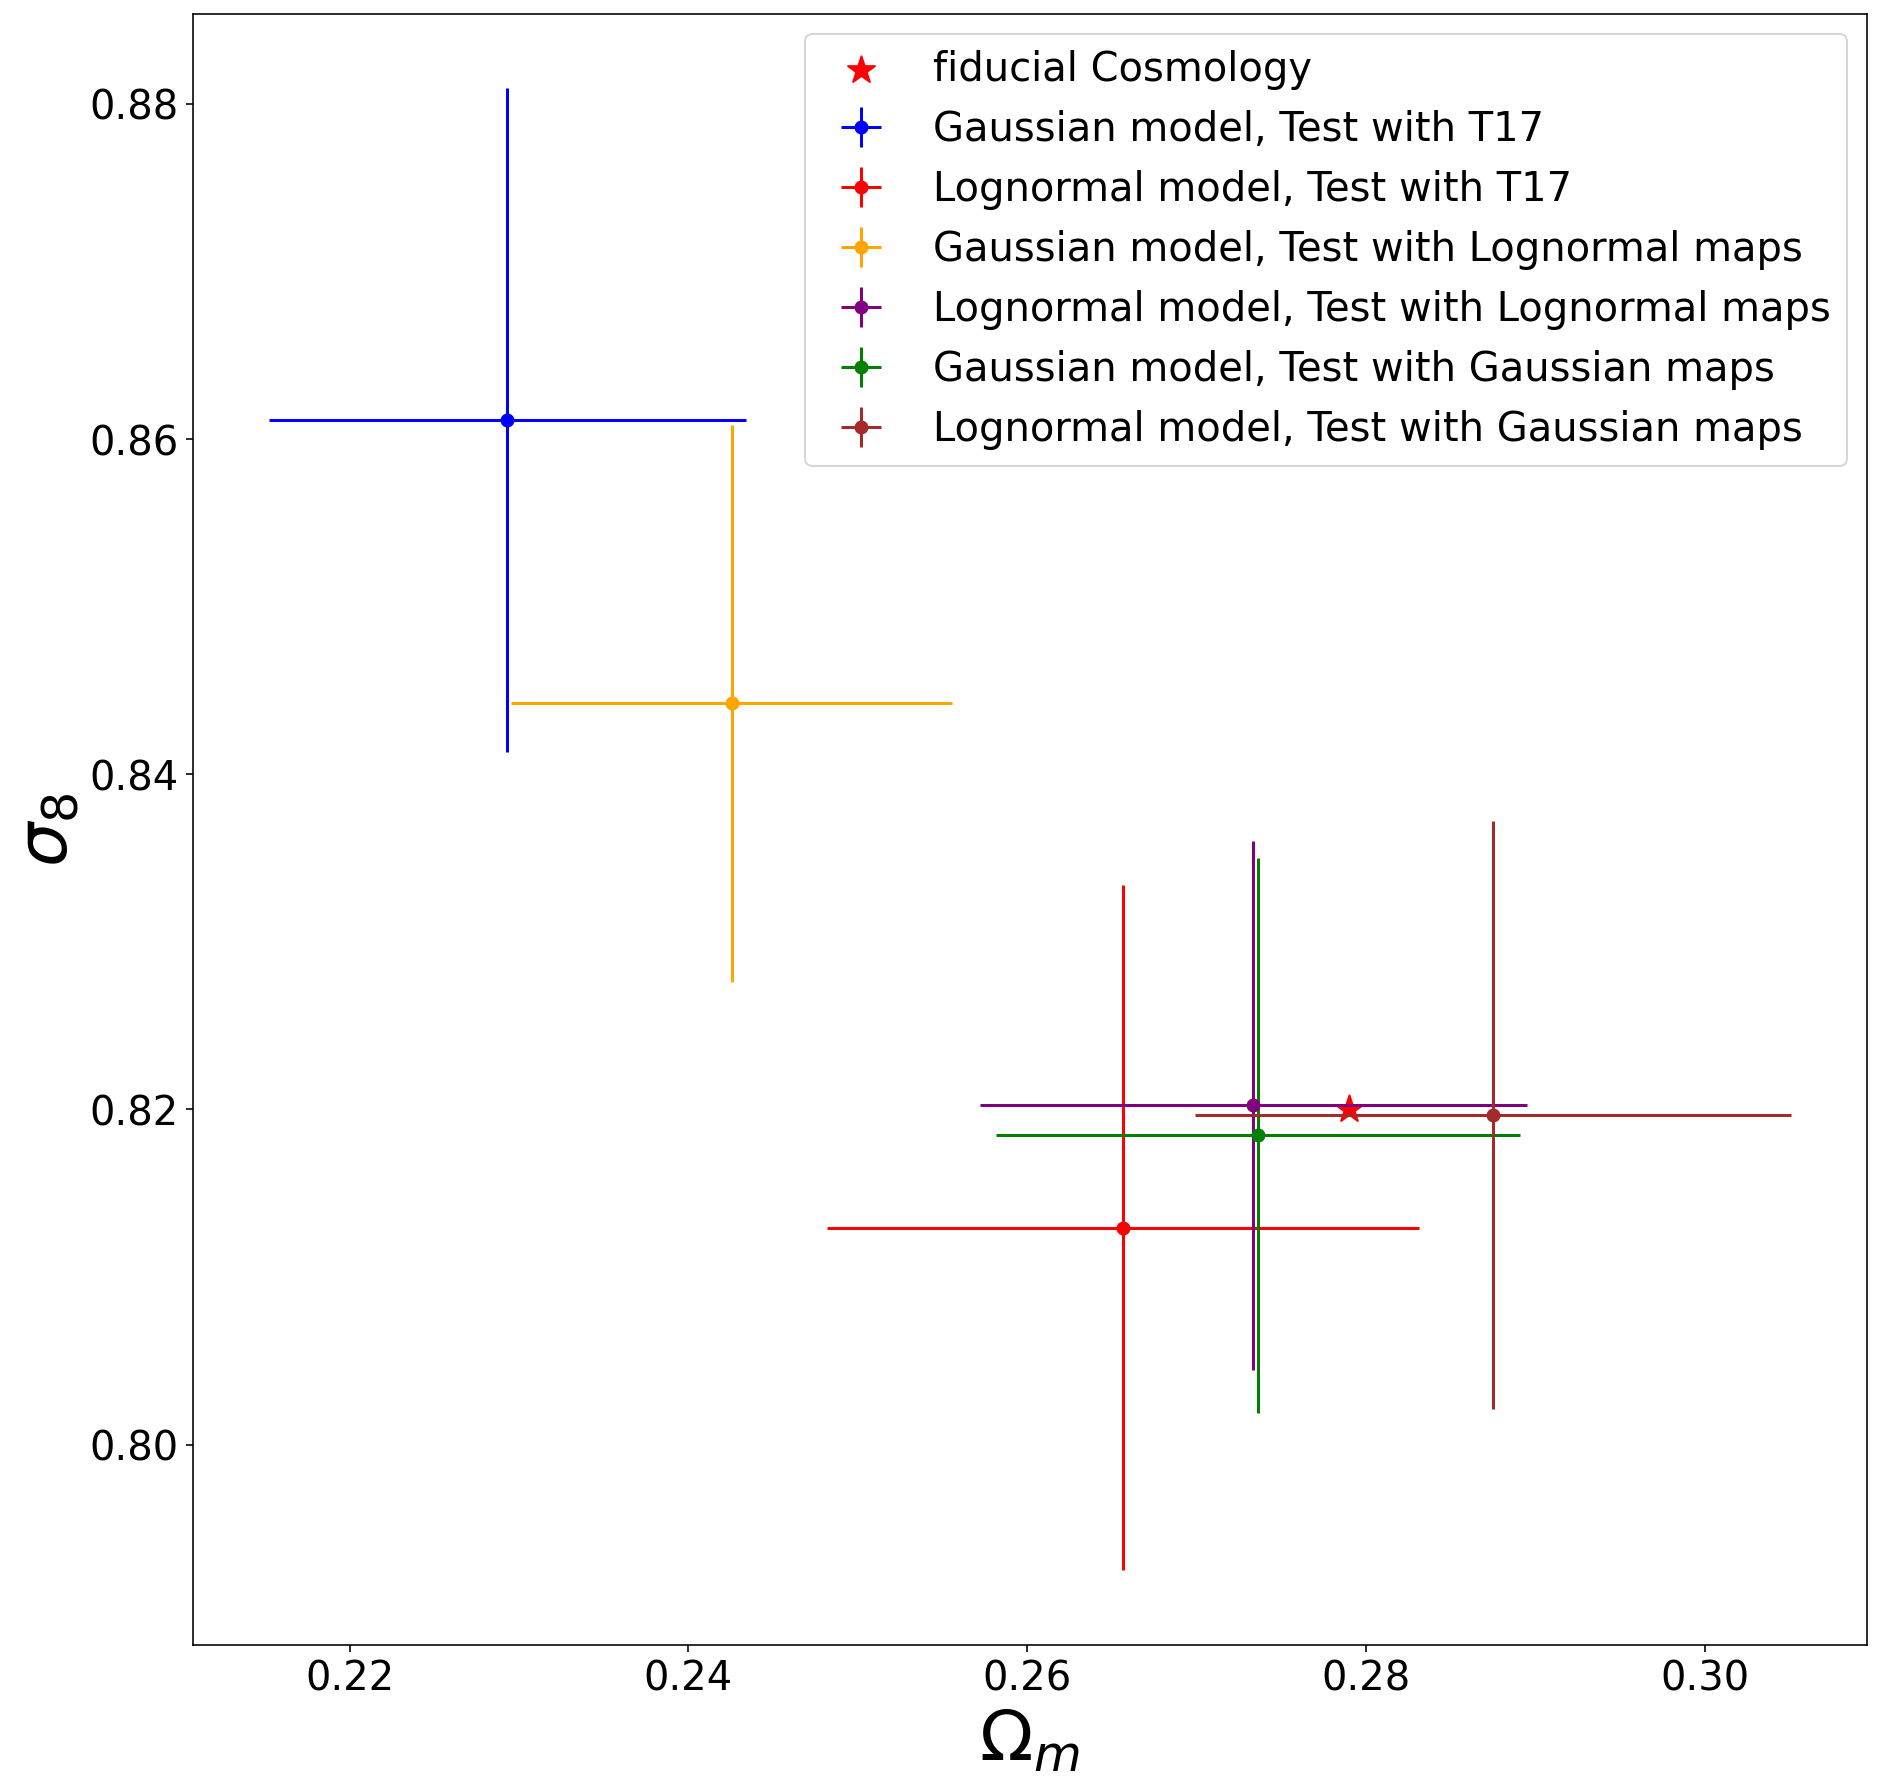

In [24]:
plt.figure(figsize=(15,15))
plt.errorbar(prediction_T17_Gauss_1_Omega_M_mean, prediction_T17_Gauss_1_sigma_8_mean, fmt='o', xerr=np.sqrt(var_T17_Gauss_1_Omega_M), yerr=np.sqrt(var_T17_Gauss_1_sigma_8),color='blue',label='Gaussian model, Test with T17')
plt.errorbar(prediction_T17_lognormal_1_Omega_M_mean, prediction_T17_lognormal_1_sigma_8_mean, fmt='o', xerr=np.sqrt(var_T17_lognormal_1_Omega_M), yerr=np.sqrt(var_T17_lognormal_1_sigma_8),color='red',label='Lognormal model, Test with T17')
plt.errorbar(prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_1_Gauss_1_sigma_8_mean, fmt='o', xerr=np.sqrt(var_lognormal_1_Gauss_1_Omega_M), yerr=np.sqrt(var_lognormal_1_Gauss_1_sigma_8),color='orange',label='Gaussian model, Test with Lognormal maps')
plt.errorbar(prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_1_lognormal_1_sigma_8_mean, fmt='o', xerr=np.sqrt(var_lognormal_1_lognormal_1_Omega_M), yerr=np.sqrt(var_lognormal_1_lognormal_1_sigma_8),color='purple',label='Lognormal model, Test with Lognormal maps')
plt.errorbar(prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_1_Gauss_1_sigma_8_mean, fmt='o', xerr=np.sqrt(var_Gauss_1_Gauss_1_Omega_M), yerr=np.sqrt(var_Gauss_1_Gauss_1_sigma_8),color='green',label='Gaussian model, Test with Gaussian maps')
plt.errorbar(prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_1_lognormal_1_sigma_8_mean, fmt='o', xerr=np.sqrt(var_Gauss_1_lognormal_1_Omega_M), yerr=np.sqrt(var_Gauss_1_lognormal_1_sigma_8),color='brown',label='Lognormal model, Test with Gaussian maps')
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', label='fiducial Cosmology', s=200, color="red")
plt.legend(fontsize=20) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(f"$\sigma_8$", fontsize=35)
plt.xlabel(f"$\Omega_m$", fontsize=35)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Test_prediction_mean_2D_11.jpg',bbox_inches='tight')
plt.show();

#### The error bar shows one $\sigma$ frequentist's interval.
#### It is the centered around the mean (maximum of $\chi^2$) of predictions

In [25]:
def dis(predic1_x, predic1_y, predic2_x, predic2_y):
    dis = np.sqrt((predic1_x-predic2_x)**2+(predic1_y-predic2_y)**2)
    return dis

In [26]:
dis_lognormal_lognormal = dis(prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_1_lognormal_1_sigma_8_mean,prediction_lognormal_2_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_sigma_8_mean)
dis_lognormal_Gauss     = dis(prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_1_Gauss_1_sigma_8_mean,prediction_lognormal_2_Gauss_1_Omega_M_mean, prediction_lognormal_2_Gauss_1_sigma_8_mean)
dis_Gauss_lognormal     = dis(prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_1_lognormal_1_sigma_8_mean,prediction_Gauss_2_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_sigma_8_mean)
dis_Gauss_Gauss         = dis(prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_1_Gauss_1_sigma_8_mean,prediction_Gauss_2_Gauss_1_Omega_M_mean, prediction_Gauss_2_Gauss_1_sigma_8_mean)

In [27]:
def frac_diff(x,y):
    frac=np.abs(1.-x/y)
    return frac

In [28]:
fr_dis_ll_Om = frac_diff(prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_Omega_M_mean)
fr_dis_lg_Om = frac_diff(prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_2_Gauss_1_Omega_M_mean)
fr_dis_gl_Om = frac_diff(prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_2_lognormal_1_Omega_M_mean)
fr_dis_gg_Om = frac_diff(prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_2_Gauss_1_Omega_M_mean)

fr_dis_ll_sg = frac_diff(prediction_lognormal_1_lognormal_1_sigma_8_mean, prediction_lognormal_2_lognormal_1_sigma_8_mean)
fr_dis_lg_sg = frac_diff(prediction_lognormal_1_Gauss_1_sigma_8_mean, prediction_lognormal_2_Gauss_1_sigma_8_mean)
fr_dis_gl_sg = frac_diff(prediction_Gauss_1_lognormal_1_sigma_8_mean, prediction_Gauss_2_lognormal_1_sigma_8_mean)
fr_dis_gg_sg = frac_diff(prediction_Gauss_1_Gauss_1_sigma_8_mean, prediction_Gauss_2_Gauss_1_sigma_8_mean)

In [58]:
print(np.sqrt((var_lognormal_1_lognormal_1_Omega_M)**2+(var_lognormal_1_lognormal_1_sigma_8)**2))
print(np.sqrt((var_Gauss_1_lognormal_1_Omega_M)**2+(var_Gauss_1_lognormal_1_sigma_8)**2))
print(var_Gauss_1_lognormal_1_Omega_M)
print(var_Gauss_1_lognormal_1_sigma_8)

0.00036036835501981933
0.00043626623500665925
0.00030869626779620065
0.0003082772162447008


In [30]:
datasets = [
    {
        'x': prediction_T17_Gauss_1_Omega_M_mean,
        'y': prediction_T17_Gauss_1_sigma_8_mean,
        'var_x': var_T17_Gauss_1_Omega_M,
        'var_y': var_T17_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with T17'
    },
    {
        'x': prediction_T17_Gauss_2_Omega_M_mean,
        'y': prediction_T17_Gauss_2_sigma_8_mean,
        'var_x': var_T17_Gauss_2_Omega_M,
        'var_y': var_T17_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with T17'
    },
   {
        'x': prediction_T17_lognormal_1_Omega_M_mean,
        'y': prediction_T17_lognormal_1_sigma_8_mean,
        'var_x': var_T17_lognormal_1_Omega_M,
        'var_y': var_T17_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with T17'
    },
    {
        'x': prediction_T17_lognormal_2_Omega_M_mean,
        'y': prediction_T17_lognormal_2_sigma_8_mean,
        'var_x': var_T17_lognormal_2_Omega_M,
        'var_y': var_T17_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with T17'
    },
    {
        'x': prediction_lognormal_1_Gauss_1_Omega_M_mean,
        'y': prediction_lognormal_1_Gauss_1_sigma_8_mean,
        'var_x': var_lognormal_1_Gauss_1_Omega_M,
        'var_y': var_lognormal_1_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with lognormal maps 1'
    },
    {
        'x': prediction_lognormal_2_Gauss_1_Omega_M_mean,
        'y': prediction_lognormal_2_Gauss_1_sigma_8_mean,
        'var_x': var_lognormal_2_Gauss_1_Omega_M,
        'var_y': var_lognormal_2_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with lognormal maps 2'
    },
    {
        'x': prediction_lognormal_1_Gauss_2_Omega_M_mean,
        'y': prediction_lognormal_1_Gauss_2_sigma_8_mean,
        'var_x': var_lognormal_1_Gauss_2_Omega_M,
        'var_y': var_lognormal_1_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with lognormal maps 1'
    },
    {
        'x': prediction_lognormal_2_Gauss_2_Omega_M_mean,
        'y': prediction_lognormal_2_Gauss_2_sigma_8_mean,
        'var_x': var_lognormal_2_Gauss_2_Omega_M,
        'var_y': var_lognormal_2_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with lognormal maps 2'
    },
    {
        'x': prediction_lognormal_1_lognormal_1_Omega_M_mean,
        'y': prediction_lognormal_1_lognormal_1_sigma_8_mean,
        'var_x': var_lognormal_1_lognormal_1_Omega_M,
        'var_y': var_lognormal_1_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with lognormal maps 1'
    },
    {
        'x': prediction_lognormal_2_lognormal_1_Omega_M_mean,
        'y': prediction_lognormal_2_lognormal_1_sigma_8_mean,
        'var_x': var_lognormal_2_lognormal_1_Omega_M,
        'var_y': var_lognormal_2_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with lognormal maps 2'
    },
    {
        'x': prediction_lognormal_1_lognormal_2_Omega_M_mean,
        'y': prediction_lognormal_1_lognormal_2_sigma_8_mean,
        'var_x': var_lognormal_1_lognormal_2_Omega_M,
        'var_y': var_lognormal_1_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with lognormal maps 1'
    },
    {
        'x': prediction_lognormal_2_lognormal_2_Omega_M_mean,
        'y': prediction_lognormal_2_lognormal_2_sigma_8_mean,
        'var_x': var_lognormal_2_lognormal_2_Omega_M,
        'var_y': var_lognormal_2_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with lognormal maps 2'
    },
    {
        'x': prediction_Gauss_1_Gauss_1_Omega_M_mean,
        'y': prediction_Gauss_1_Gauss_1_sigma_8_mean,
        'var_x': var_Gauss_1_Gauss_1_Omega_M,
        'var_y': var_Gauss_1_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with Gaussian maps 1'
    },
    {
        'x': prediction_Gauss_2_Gauss_1_Omega_M_mean,
        'y': prediction_Gauss_2_Gauss_1_sigma_8_mean,
        'var_x': var_Gauss_2_Gauss_1_Omega_M,
        'var_y': var_Gauss_2_Gauss_1_sigma_8,
        'label': 'Gaussian model 1, Test with Gaussian maps 2'
    },
    {
        'x': prediction_Gauss_1_Gauss_2_Omega_M_mean,
        'y': prediction_Gauss_1_Gauss_2_sigma_8_mean,
        'var_x': var_Gauss_1_Gauss_2_Omega_M,
        'var_y': var_Gauss_1_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with Gaussian maps 1'
    },
    {
        'x': prediction_Gauss_2_Gauss_2_Omega_M_mean,
        'y': prediction_Gauss_2_Gauss_2_sigma_8_mean,
        'var_x': var_Gauss_2_Gauss_2_Omega_M,
        'var_y': var_Gauss_2_Gauss_2_sigma_8,
        'label': 'Gaussian model 2, Test with Gaussian maps 2'
    },
    {
        'x': prediction_Gauss_1_lognormal_1_Omega_M_mean,
        'y': prediction_Gauss_1_lognormal_1_sigma_8_mean,
        'var_x': var_Gauss_1_lognormal_1_Omega_M,
        'var_y': var_Gauss_1_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with Gaussian maps 1'
    },
    {
        'x': prediction_Gauss_2_lognormal_1_Omega_M_mean,
        'y': prediction_Gauss_2_lognormal_1_sigma_8_mean,
        'var_x': var_Gauss_2_lognormal_1_Omega_M,
        'var_y': var_Gauss_2_lognormal_1_sigma_8,
        'label': 'Lognormal model 1, Test with Gaussian maps 2'
    },
    {
        'x': prediction_Gauss_1_lognormal_2_Omega_M_mean,
        'y': prediction_Gauss_1_lognormal_2_sigma_8_mean,
        'var_x': var_Gauss_1_lognormal_2_Omega_M,
        'var_y': var_Gauss_1_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with Gaussian maps 1'
    },
    {
        'x': prediction_Gauss_2_lognormal_2_Omega_M_mean,
        'y': prediction_Gauss_2_lognormal_2_sigma_8_mean,
        'var_x': var_Gauss_2_lognormal_2_Omega_M,
        'var_y': var_Gauss_2_lognormal_2_sigma_8,
        'label': 'Lognormal model 2, Test with Gaussian maps 2'
    }
]

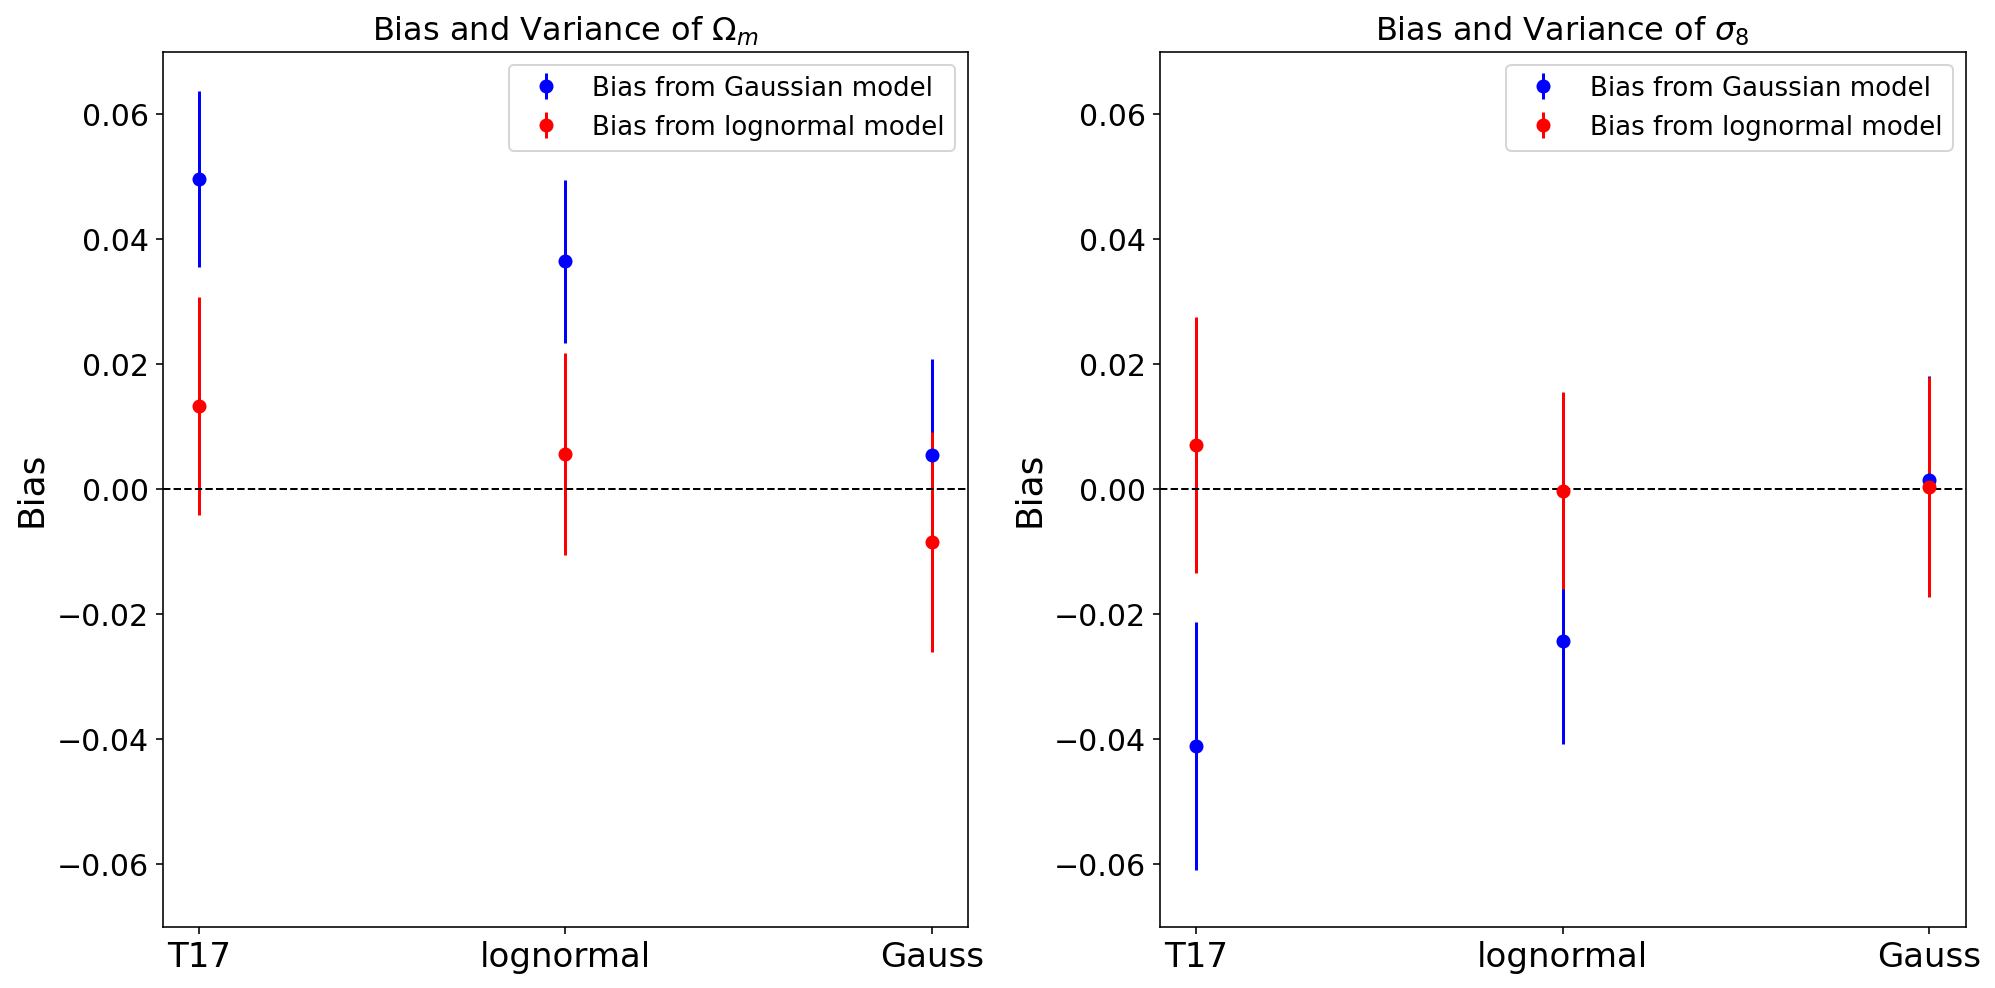

In [32]:
labels = ['T17', 'lognormal', 'Gauss']
bias_Omega_M_Gauss_1         = [bias_T17_Gauss_1_Omega_M, bias_lognormal_1_Gauss_1_Omega_M, bias_Gauss_1_Gauss_1_Omega_M]
variance_Omega_M_Gauss_1     = [var_T17_Gauss_1_Omega_M, var_lognormal_1_Gauss_1_Omega_M, var_Gauss_1_Gauss_1_Omega_M]
bias_Omega_M_lognormal_1     = [bias_T17_lognormal_1_Omega_M, bias_lognormal_1_lognormal_1_Omega_M, bias_Gauss_1_lognormal_1_Omega_M]
variance_Omega_M_lognormal_1 = [var_T17_lognormal_1_Omega_M, var_lognormal_1_lognormal_1_Omega_M, var_Gauss_1_lognormal_1_Omega_M]

bias_sigma_8_Gauss_1         = [bias_T17_Gauss_1_sigma_8, bias_lognormal_1_Gauss_1_sigma_8, bias_Gauss_1_Gauss_1_sigma_8]
variance_sigma_8_Gauss_1     = [var_T17_Gauss_1_sigma_8, var_lognormal_1_Gauss_1_sigma_8, var_Gauss_1_Gauss_1_sigma_8]
bias_sigma_8_lognormal_1     = [bias_T17_lognormal_1_sigma_8, bias_lognormal_1_lognormal_1_sigma_8, bias_Gauss_1_lognormal_1_sigma_8]
variance_sigma_8_lognormal_1 = [var_T17_lognormal_1_sigma_8, var_lognormal_1_lognormal_1_sigma_8, var_Gauss_1_lognormal_1_sigma_8]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot bias for Omega_M
ax1.errorbar(labels, bias_Omega_M_Gauss_1, yerr=np.sqrt(variance_Omega_M_Gauss_1), fmt='o', color='b', label='Bias from Gaussian model')
ax1.errorbar(labels, bias_Omega_M_lognormal_1, yerr=np.sqrt(variance_Omega_M_lognormal_1), fmt='o', color='r', label='Bias from lognormal model')
ax1.set_title('Bias and Variance of $\Omega_m$', fontsize=16)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=1) 
ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylim(-0.07,0.07)
ax1.set_ylabel('Bias', fontsize=18)
ax1.legend(fontsize=13)

# Plot bias for sigma_8
ax2.errorbar(labels, bias_sigma_8_Gauss_1, yerr=np.sqrt(variance_sigma_8_Gauss_1), fmt='o', color='b', label='Bias from Gaussian model')
ax2.errorbar(labels, bias_sigma_8_lognormal_1, yerr=np.sqrt(variance_sigma_8_lognormal_1), fmt='o', color='r', label='Bias from lognormal model')
ax2.set_title('Bias and Variance of $\sigma_8$', fontsize=16)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax2.tick_params(axis='x', labelsize=17)
ax2.tick_params(axis='y', labelsize=15)
ax2.set_ylabel('Bias', fontsize=18)
ax2.set_ylim(-0.07,0.07)
ax2.legend(fontsize=13)

plt.tight_layout()
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Bias_variance_11.jpg',bbox_inches='tight')
plt.show();

#### 0 is good point. 
#### Gaussian model -> Test T17 -> outside of one $\sigma$ in both parameters
#### Gaussian model -> Test lognormal -> outside of one $\sigma$ in both parameters

In [33]:
dis_T17_Gauss_1             = np.sqrt((bias_T17_Gauss_1_Omega_M)**2+(bias_T17_Gauss_1_sigma_8)**2)
dis_T17_Gauss_2             = np.sqrt((bias_T17_Gauss_2_Omega_M)**2+(bias_T17_Gauss_2_sigma_8)**2)
dis_Gauss_1_Gauss_1         = np.sqrt((bias_Gauss_1_Gauss_1_Omega_M)**2+(bias_Gauss_1_Gauss_1_sigma_8)**2)
dis_lognormal_1_Gauss_1     = np.sqrt((bias_lognormal_1_Gauss_1_Omega_M)**2+(bias_lognormal_1_Gauss_1_sigma_8)**2)
dis_Gauss_2_Gauss_1         = np.sqrt((bias_Gauss_2_Gauss_1_Omega_M)**2+(bias_Gauss_2_Gauss_1_sigma_8)**2)
dis_lognormal_2_Gauss_1     = np.sqrt((bias_lognormal_2_Gauss_1_Omega_M)**2+(bias_lognormal_2_Gauss_1_sigma_8)**2)
dis_Gauss_1_Gauss_2         = np.sqrt((bias_Gauss_1_Gauss_2_Omega_M)**2+(bias_Gauss_1_Gauss_2_sigma_8)**2)
dis_lognormal_1_Gauss_2     = np.sqrt((bias_lognormal_1_Gauss_2_Omega_M)**2+(bias_lognormal_1_Gauss_2_sigma_8)**2)
dis_Gauss_2_Gauss_2         = np.sqrt((bias_Gauss_2_Gauss_2_Omega_M)**2+(bias_Gauss_2_Gauss_2_sigma_8)**2)
dis_lognormal_2_Gauss_2     = np.sqrt((bias_lognormal_2_Gauss_2_Omega_M)**2+(bias_lognormal_2_Gauss_2_sigma_8)**2)
dis_T17_lognormal_1         = np.sqrt((bias_T17_lognormal_1_Omega_M)**2+(bias_T17_lognormal_1_sigma_8)**2)
dis_T17_lognormal_2         = np.sqrt((bias_T17_lognormal_2_Omega_M)**2+(bias_T17_lognormal_2_sigma_8)**2)
dis_Gauss_1_lognormal_1     = np.sqrt((bias_Gauss_1_lognormal_1_Omega_M)**2+(bias_Gauss_1_lognormal_1_sigma_8)**2)
dis_lognormal_1_lognormal_1 = np.sqrt((bias_lognormal_1_lognormal_1_Omega_M)**2+(bias_lognormal_1_lognormal_1_sigma_8)**2)
dis_Gauss_2_lognormal_1     = np.sqrt((bias_Gauss_2_lognormal_1_Omega_M)**2+(bias_Gauss_2_lognormal_1_sigma_8)**2)
dis_lognormal_2_lognormal_1 = np.sqrt((bias_lognormal_2_lognormal_1_Omega_M)**2+(bias_lognormal_2_lognormal_1_sigma_8)**2)
dis_Gauss_1_lognormal_2     = np.sqrt((bias_Gauss_1_lognormal_2_Omega_M)**2+(bias_Gauss_1_lognormal_2_sigma_8)**2)
dis_lognormal_1_lognormal_2 = np.sqrt((bias_lognormal_1_lognormal_2_Omega_M)**2+(bias_lognormal_1_lognormal_2_sigma_8)**2)
dis_Gauss_2_lognormal_2     = np.sqrt((bias_Gauss_2_lognormal_2_Omega_M)**2+(bias_Gauss_2_lognormal_2_sigma_8)**2)
dis_lognormal_2_lognormal_2 = np.sqrt((bias_lognormal_2_lognormal_2_Omega_M)**2+(bias_lognormal_2_lognormal_2_sigma_8)**2)

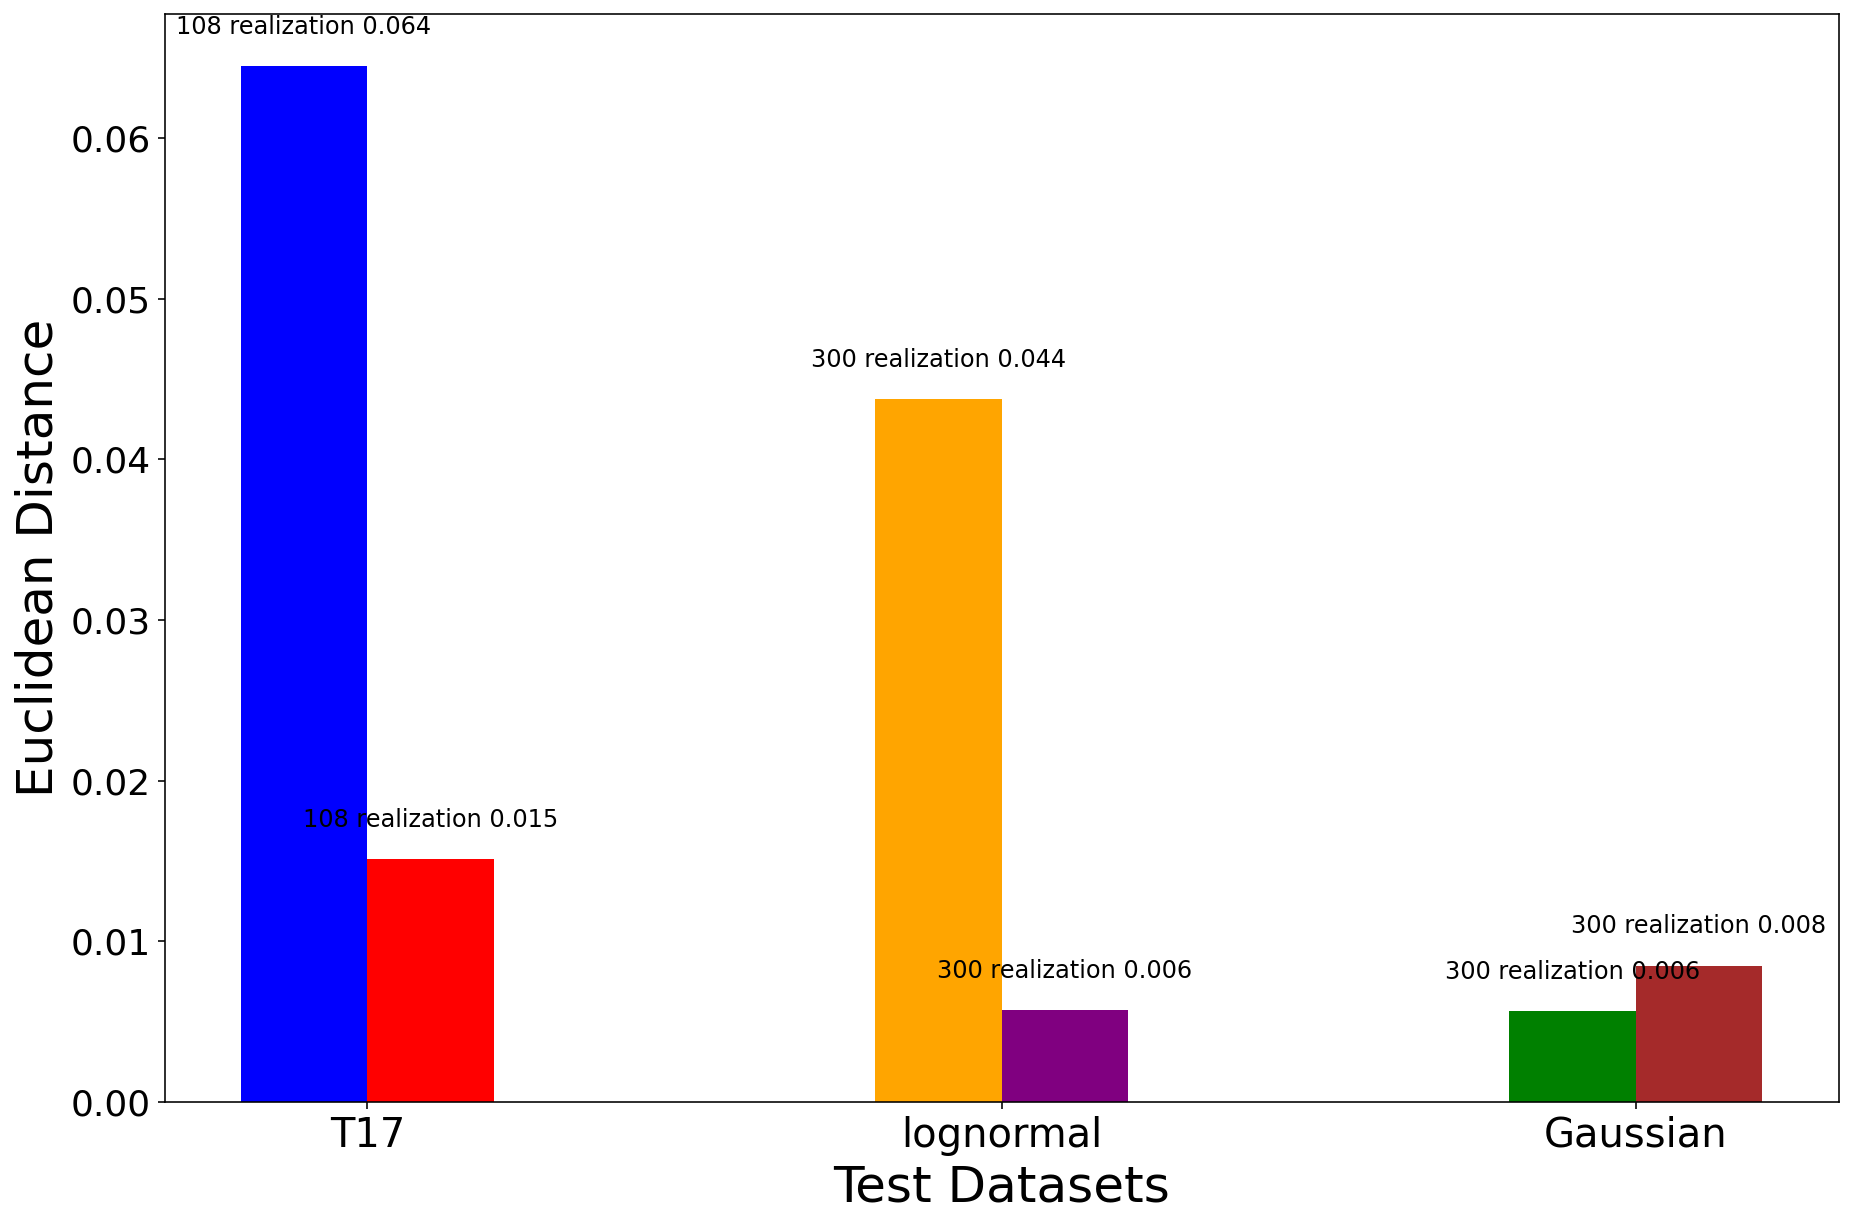

In [34]:
bias_indicators = ['T17', 'lognormal', 'Gaussian']
bar_width = 0.2  # Width of each bar
bar_positions = range(len(bias_indicators))  # X-axis positions for bars
colors1 = ['blue', 'orange','green']
colors2 = ['red', 'purple', 'brown']
# Example data (replace with your actual data)
dis_Gauss_11          = [dis_T17_Gauss_1, dis_lognormal_1_Gauss_1, dis_Gauss_1_Gauss_1]
dis_Gauss_12          = [dis_T17_Gauss_2, dis_lognormal_1_Gauss_2, dis_Gauss_1_Gauss_2]
dis_Gauss_21          = [dis_T17_Gauss_1, dis_lognormal_2_Gauss_1, dis_Gauss_2_Gauss_1]
dis_Gauss_22          = [dis_T17_Gauss_2, dis_lognormal_2_Gauss_2, dis_Gauss_2_Gauss_2]
dis_lognormal_11      = [dis_T17_lognormal_1, dis_lognormal_1_lognormal_1,dis_Gauss_1_lognormal_1]
dis_lognormal_12      = [dis_T17_lognormal_2, dis_lognormal_1_lognormal_2,dis_Gauss_1_lognormal_2]
dis_lognormal_21      = [dis_T17_lognormal_1, dis_lognormal_2_lognormal_1,dis_Gauss_2_lognormal_1]
dis_lognormal_22      = [dis_T17_lognormal_2, dis_lognormal_2_lognormal_2,dis_Gauss_2_lognormal_2]
plt.figure(figsize=(15, 10))
for i, v in enumerate(dis_Gauss_11):
    if i==0:
        plt.text(i - bar_width *0.5, v + 0.002, f'108 realization {v:.3f}', color='black', ha='center', fontsize=12)
    else:
        plt.text(i - bar_width *0.5, v + 0.002, f'300 realization {v:.3f}', color='black', ha='center', fontsize=12)
for i, v in enumerate(dis_lognormal_11):
    if i==0:
        plt.text(i + bar_width *0.5, v + 0.002, f'108 realization {v:.3f}', color='black', ha='center', fontsize=12)
    else:
        plt.text(i + bar_width *0.5, v + 0.002, f'300 realization {v:.3f}', color='black', ha='center', fontsize=12)
plt.bar([pos - bar_width * 0.5 for pos in bar_positions], dis_Gauss_11, width=bar_width, color=colors1, label='Trained with Gaussian')
plt.bar([pos + bar_width * 0.5 for pos in bar_positions], dis_lognormal_11, width=bar_width, color=colors2, label='Trained with lognormal')
plt.yticks(fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('Euclidean Distance', fontsize=25)
plt.xlabel('Test Datasets', fontsize=25)
plt.xticks(bar_positions, bias_indicators)
#plt.legend(fontsize=15)
#plt.title('Bias Indicator Values', fontsize=20)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/bias_indicatos_11.jpg',bbox_inches='tight')
plt.show();

#### Bias ranking
#### Why lognormal vs T17 is higher than lognoral vs. Gaussian 

# Part. 3 Sample Covariance
#### We can simply get this from definition below:
$$
C_{i,j}=\frac{1}{N_s-1}\sum^{N_s}_{s=1}(\theta-\langle\theta\rangle)^T(\theta-\langle\theta\rangle)
$$

In [35]:
mu_T17_Gauss_1                  = np.array((prediction_T17_Gauss_1_Omega_M_mean, prediction_T17_Gauss_1_sigma_8_mean)).T
mu_T17_Gauss_2                  = np.array((prediction_T17_Gauss_2_Omega_M_mean, prediction_T17_Gauss_2_sigma_8_mean)).T
mu_lognormal_1_Gauss_1          = np.array((prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_1_Gauss_1_sigma_8_mean)).T
mu_lognormal_1_Gauss_2          = np.array((prediction_lognormal_1_Gauss_2_Omega_M_mean, prediction_lognormal_1_Gauss_2_sigma_8_mean)).T
mu_lognormal_2_Gauss_1          = np.array((prediction_lognormal_2_Gauss_1_Omega_M_mean, prediction_lognormal_2_Gauss_1_sigma_8_mean)).T
mu_lognormal_2_Gauss_2          = np.array((prediction_lognormal_2_Gauss_2_Omega_M_mean, prediction_lognormal_2_Gauss_2_sigma_8_mean)).T
mu_Gauss_1_Gauss_1              = np.array((prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_1_Gauss_1_sigma_8_mean)).T
mu_Gauss_1_Gauss_2              = np.array((prediction_Gauss_1_Gauss_2_Omega_M_mean, prediction_Gauss_1_Gauss_2_sigma_8_mean)).T
mu_Gauss_2_Gauss_1              = np.array((prediction_Gauss_2_Gauss_1_Omega_M_mean, prediction_Gauss_2_Gauss_1_sigma_8_mean)).T
mu_Gauss_2_Gauss_2              = np.array((prediction_Gauss_2_Gauss_2_Omega_M_mean, prediction_Gauss_2_Gauss_2_sigma_8_mean)).T
mu_T17_lognormal_1              = np.array((prediction_T17_lognormal_1_Omega_M_mean, prediction_T17_lognormal_1_sigma_8_mean)).T
mu_T17_lognormal_2              = np.array((prediction_T17_lognormal_2_Omega_M_mean, prediction_T17_lognormal_2_sigma_8_mean)).T
mu_lognormal_1_lognormal_1      = np.array((prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_1_lognormal_1_sigma_8_mean)).T
mu_lognormal_1_lognormal_2      = np.array((prediction_lognormal_1_lognormal_2_Omega_M_mean, prediction_lognormal_1_lognormal_2_sigma_8_mean)).T
mu_lognormal_2_lognormal_1      = np.array((prediction_lognormal_2_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_sigma_8_mean)).T
mu_lognormal_2_lognormal_2      = np.array((prediction_lognormal_2_lognormal_2_Omega_M_mean, prediction_lognormal_2_lognormal_2_sigma_8_mean)).T
mu_Gauss_1_lognormal_1          = np.array((prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_1_lognormal_1_sigma_8_mean)).T
mu_Gauss_1_lognormal_2          = np.array((prediction_Gauss_1_lognormal_2_Omega_M_mean, prediction_Gauss_1_lognormal_2_sigma_8_mean)).T
mu_Gauss_2_lognormal_1          = np.array((prediction_Gauss_2_lognormal_1_Omega_M_mean, prediction_Gauss_2_lognormal_1_sigma_8_mean)).T
mu_Gauss_2_lognormal_2          = np.array((prediction_Gauss_2_lognormal_2_Omega_M_mean, prediction_Gauss_2_lognormal_2_sigma_8_mean)).T
cov_T17_Gauss_1_KDE             = cov(mu_T17_Gauss_1, prediction_T17_Gauss_1[:,:2])
cov_T17_Gauss_2_KDE             = cov(mu_T17_Gauss_2, prediction_T17_Gauss_2[:,:2])
cov_lognormal_1_Gauss_1_KDE     = cov(mu_lognormal_1_Gauss_1, prediction_lognormal_1_Gauss_1[:,:2])
cov_lognormal_1_Gauss_2_KDE     = cov(mu_lognormal_1_Gauss_2, prediction_lognormal_1_Gauss_2[:,:2])
cov_lognormal_2_Gauss_1_KDE     = cov(mu_lognormal_2_Gauss_1, prediction_lognormal_2_Gauss_1[:,:2])
cov_lognormal_2_Gauss_2_KDE     = cov(mu_lognormal_2_Gauss_2, prediction_lognormal_2_Gauss_2[:,:2])
cov_Gauss_1_Gauss_1_KDE         = cov(mu_Gauss_1_Gauss_1, prediction_Gauss_1_Gauss_1[:,:2])
cov_Gauss_1_Gauss_2_KDE         = cov(mu_Gauss_1_Gauss_2, prediction_Gauss_1_Gauss_2[:,:2])
cov_Gauss_2_Gauss_1_KDE         = cov(mu_Gauss_2_Gauss_1, prediction_Gauss_2_Gauss_1[:,:2])
cov_Gauss_2_Gauss_2_KDE         = cov(mu_Gauss_2_Gauss_2, prediction_Gauss_2_Gauss_2[:,:2])
cov_T17_lognormal_1_KDE         = cov(mu_T17_lognormal_1, prediction_T17_lognormal_1[:,:2])
cov_T17_lognormal_2_KDE         = cov(mu_T17_lognormal_2, prediction_T17_lognormal_2[:,:2])
cov_lognormal_1_lognormal_1_KDE = cov(mu_lognormal_1_lognormal_1, prediction_lognormal_1_lognormal_1[:,:2])
cov_lognormal_1_lognormal_2_KDE = cov(mu_lognormal_1_lognormal_2, prediction_lognormal_1_lognormal_2[:,:2])
cov_lognormal_2_lognormal_1_KDE = cov(mu_lognormal_2_lognormal_1, prediction_lognormal_2_lognormal_1[:,:2])
cov_lognormal_2_lognormal_2_KDE = cov(mu_lognormal_2_lognormal_2, prediction_lognormal_2_lognormal_2[:,:2])
cov_Gauss_1_lognormal_1_KDE     = cov(mu_Gauss_1_lognormal_1, prediction_Gauss_1_lognormal_1[:,:2])
cov_Gauss_1_lognormal_2_KDE     = cov(mu_Gauss_1_lognormal_2, prediction_Gauss_1_lognormal_2[:,:2])
cov_Gauss_2_lognormal_1_KDE     = cov(mu_Gauss_2_lognormal_1, prediction_Gauss_2_lognormal_1[:,:2])
cov_Gauss_2_lognormal_2_KDE     = cov(mu_Gauss_2_lognormal_2, prediction_Gauss_2_lognormal_2[:,:2])

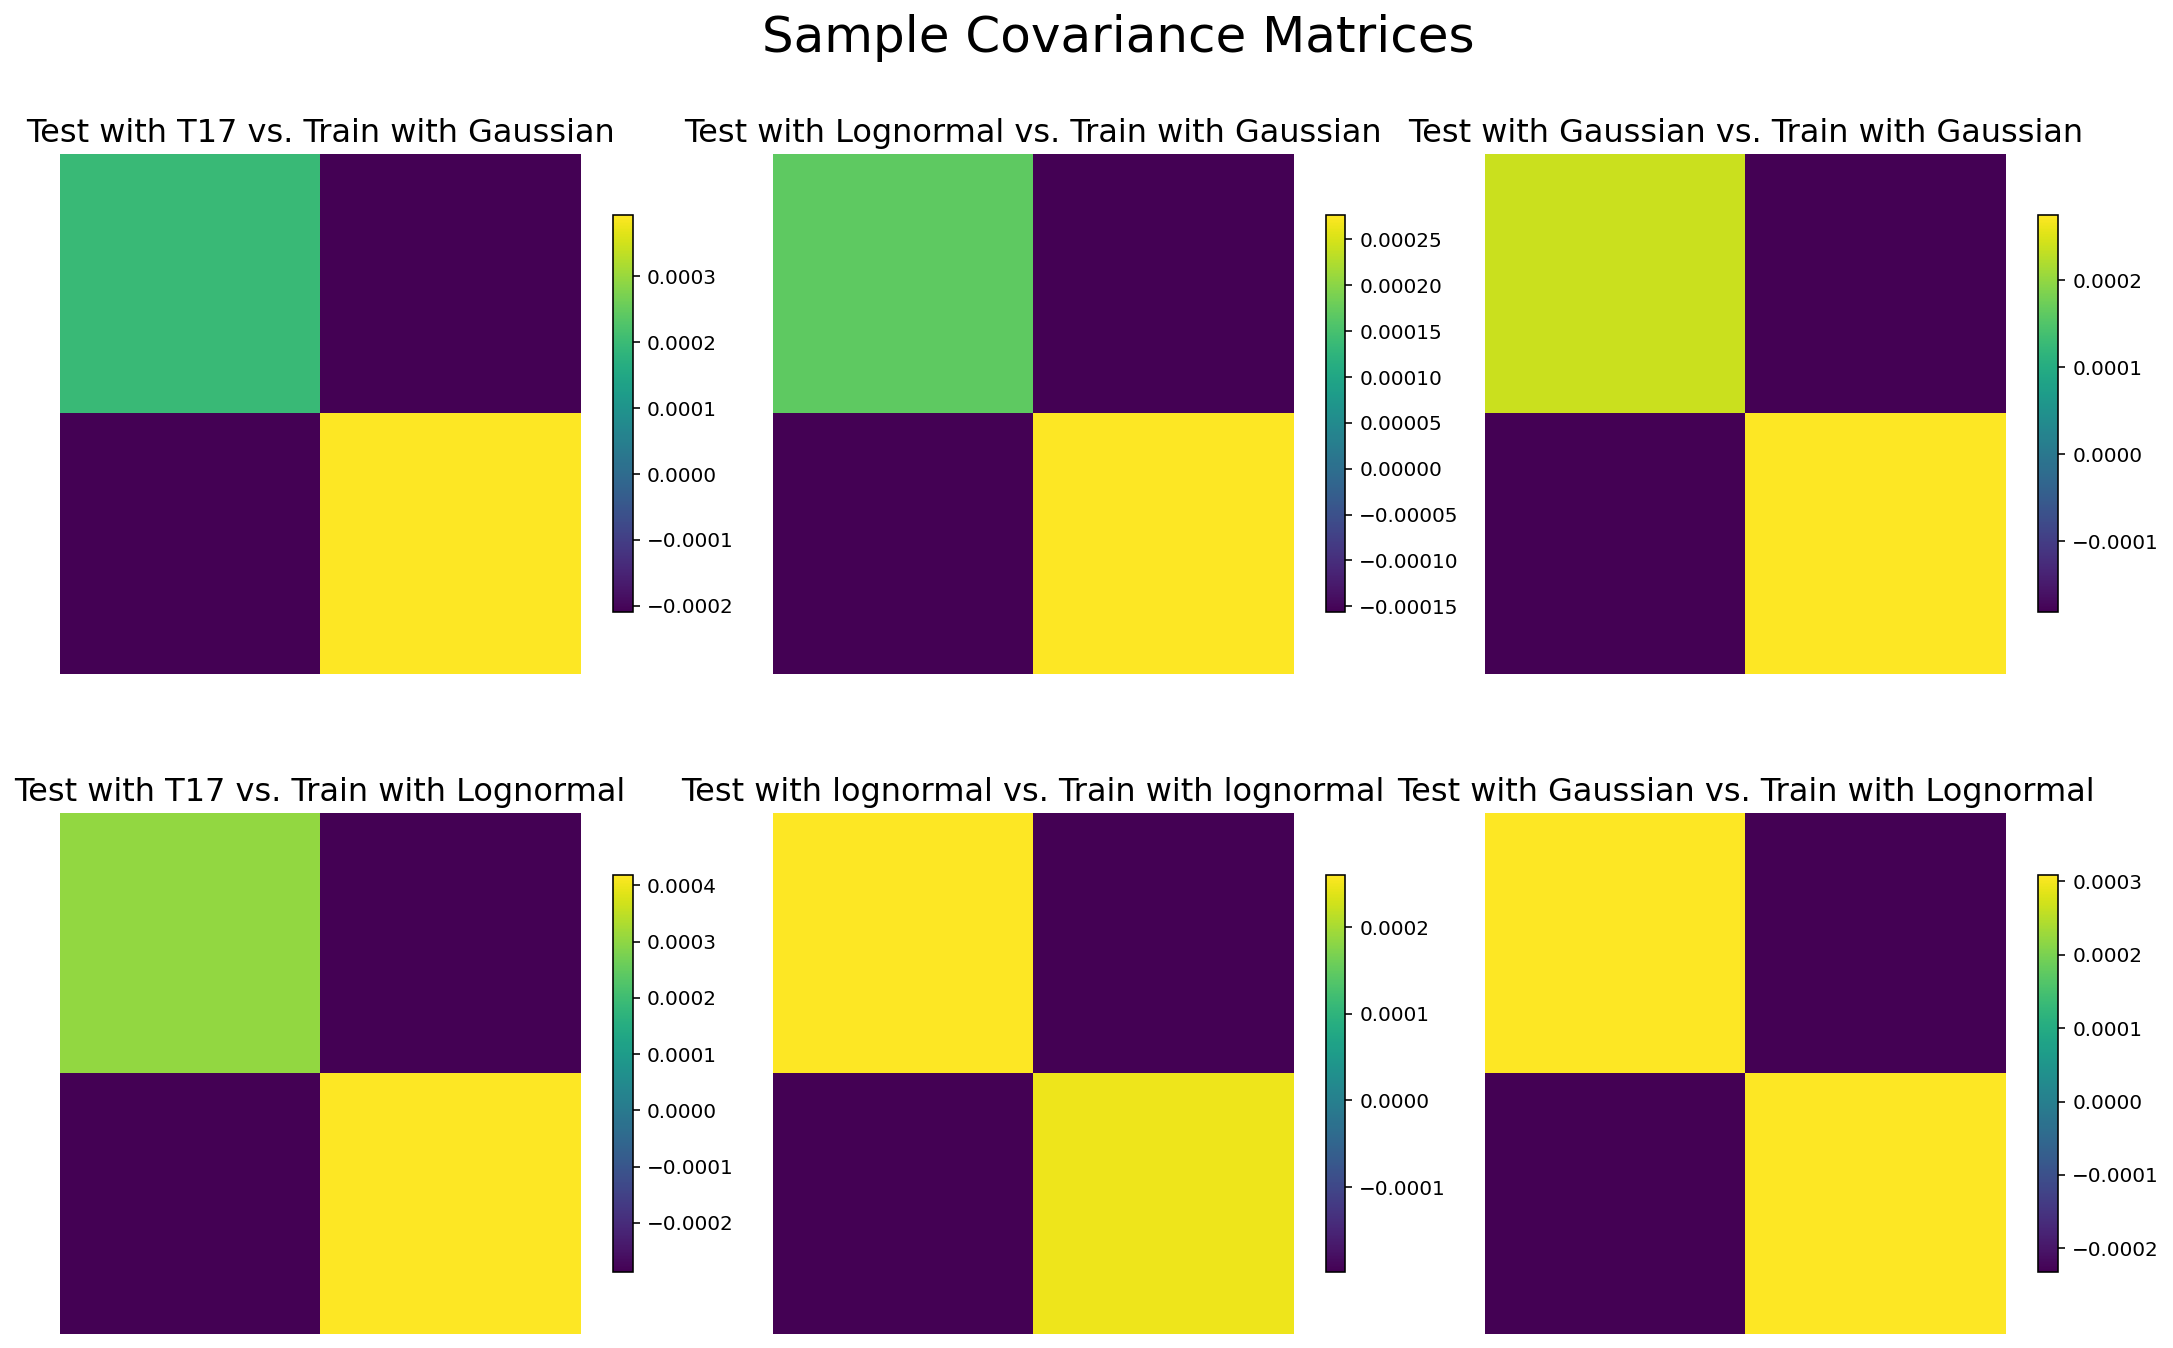

In [36]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

# List of covariance matrices and their corresponding titles
cov_matrices_KDE_1 = [
    cov_T17_Gauss_1_KDE, cov_lognormal_1_Gauss_1_KDE, cov_Gauss_1_Gauss_1_KDE
    , cov_T17_lognormal_1_KDE, cov_lognormal_1_lognormal_1_KDE, cov_Gauss_1_lognormal_1_KDE
]
titles = [
    'Test with T17 vs. Train with Gaussian', 'Test with Lognormal vs. Train with Gaussian',
    'Test with Gaussian vs. Train with Gaussian', 'Test with T17 vs. Train with Lognormal',
    'Test with lognormal vs. Train with lognormal', 'Test with Gaussian vs. Train with Lognormal'
]

# Loop through subplots and plot each covariance matrix
for ax, cov_matrix, title in zip(axes.flatten(), cov_matrices_KDE_1, titles):
    im = ax.imshow(cov_matrix, cmap='viridis')
    ax.set_title(title, fontsize=16)
    ax.axis('off')
    fig.colorbar(im, ax=ax, shrink=0.6)

# Add a title and display the plot
fig.suptitle('Sample Covariance Matrices', fontsize=25)
plt.tight_layout()
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/cov_KDE.jpg',bbox_inches='tight')
plt.show()

#### It is hard to comment, since I don't know how to intepret this...